<a href="https://colab.research.google.com/github/vedangit/Driver-Drowsiness-Predicion/blob/main/Driver%20Drowsiness.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Driver Drowsiness Detection Project

## Introduction

Welcome to the driver drowsiness detection project! In this project, we aim to develop a system that can detect drowsiness in drivers using deep learning techniques. Drowsy driving is a major cause of accidents on the road, and our goal is to create a tool that can help prevent such accidents by alerting drivers when they are showing signs of drowsiness.

## About Google Colab

We will be using Google Colab for this project. Google Colab is a free cloud service that provides a Python programming environment with free GPU access. It's a great platform for machine learning projects as it allows us to run our code in a virtual machine hosted by Google's infrastructure, making it easy to collaborate and share code with others.

## Project Overview

In this project, we will:

- Preprocess a dataset of images drivers - divided into 4 classes (closed eyes, open eyes, yawn, no yawn).
- Train a deep learning model to recognize facial features indicative of drowsiness.
- Implement an real time system to identify whether the driver is drowsy.

By the end of this project, we hope to have a working prototype that can be further optimized and deployed in real-world scenarios to improve road safety.

Let's get started!


In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

%cd /content/drive/MyDrive/

#!unzip archive.zip -d driver/

Mounted at /content/drive
/content/drive/MyDrive


In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import HTML


In [ ]:
BATCH_SIZE = 32
IMAGE_SIZE = 255
CHANNELS = 3


In [ ]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    '/content/drive/MyDrive/driver/train',
    seed = 123,
    shuffle = True,
    batch_size=BATCH_SIZE,
    image_size=(IMAGE_SIZE, IMAGE_SIZE)
)



Found 2900 files belonging to 4 classes.


In [ ]:
class_names = dataset.class_names
class_names

['Closed', 'Open', 'no_yawn', 'yawn']

##Visualizing images in every class

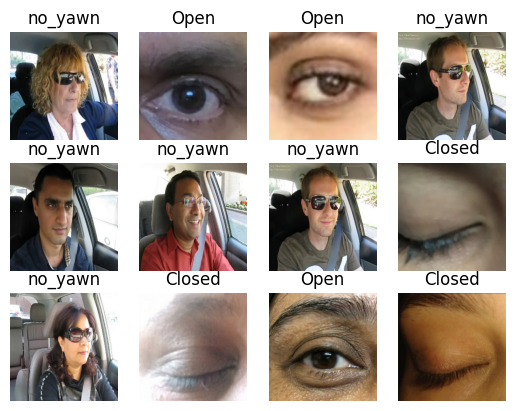

In [ ]:
for image_batch, labels_name in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype('uint8'))
        plt.title(class_names[labels_name[i]])
        plt.axis('off')

plt.show()



## Splitting the Data into Train and Test Sets

Before we proceed with training our model, it's essential to split our dataset into two subsets: one for training the model and the other for testing its performance. This helps us evaluate how well our model generalizes to new, unseen data.

### Methodology

We will use a common approach called the train-test split method. In this method, we randomly divide our dataset into two parts:

- **Training Set**: This subset of the data is used to train our machine learning model. It comprises a majority of the dataset, **80%.**
  
- **Test Set**: This subset is used to evaluate the performance of our trained model. It contains the remaining portion of the dataset, **10%.**

- **Validation Set**: This subset, **10%** of the dataset, is used to fine-tune model hyperparameters and assess model performance during training. It helps in preventing overfitting by providing an independent dataset not used for training.


### Implementation

We will utilize the `train_test_split` function from the `scikit-learn` library, which provides a simple and efficient way to split datasets.

In [ ]:
def get_split_data(ds, train_split=0.8, test_splt=0.1, val_split=0.1, shuffle=True, shuffle_size=10000):
    assert(train_split + test_splt + val_split ) == 1
    ds_size= len(ds)
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
        train_size = int(train_split * ds_size)
        val_size = int(val_split * ds_size)

        train_ds = ds.take(train_size)
        val_ds = ds.skip(train_size).take(val_size)
        test_ds = ds.skip(train_size).skip(val_size)

        return train_ds, val_ds, test_ds

In [ ]:
train_ds, val_ds, test_ds = get_split_data(dataset)

In [ ]:
print(len(train_ds))
print(len(test_ds))
print(len(val_ds))

72
10
9


In [ ]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [ ]:
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0 / 255)
])

In [ ]:
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip('horizontal_and_vertical'),
    layers.experimental.preprocessing.RandomRotation(0.2)
])

In [ ]:
train_ds = train_ds.map(
    lambda x,y: (data_augmentation(x, training=True),y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

In [ ]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 4
model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size=(3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2,2)),

    layers.Conv2D(64, kernel_size=(3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),

    layers.Conv2D(128, kernel_size=(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),

    layers.Conv2D(128, kernel_size=(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),

    layers.Conv2D(128, kernel_size=(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),

    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.BatchNormalization(),
    layers.Dense(n_classes, activation='softmax')
])
model.build(input_shape=input_shape)

model.compile(optimizer='adam',
             loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
             metrics=['accuracy'])


from tensorflow.keras.callbacks import EarlyStopping
callback = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 255, 255, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 253, 253, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (32, 126, 126, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (32, 124, 124, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (32, 62, 62, 64)          0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (32, 60, 60, 128)        

## Model Architecture

### Layer Explanation

- **Sequential Layer**: This is the primary container for the neural network model. It doesn't perform any computation itself but organizes the layers in a sequential order.

- **Conv2D Layer**: This layer creates a convolutional kernel that is convolved with the layer input to produce a tensor of outputs. It's responsible for extracting features from the input images through convolution operations.

- **MaxPooling2D Layer**: This layer performs max pooling operation on the spatial dimensions of the input data. It helps in reducing the spatial dimensions while retaining the important information.

- **Flatten Layer**: This layer flattens the input without affecting the batch size. It converts the multi-dimensional tensor into a one-dimensional tensor, which is required before passing the data to the dense layers.

- **Dense Layer**: Also known as a fully connected layer, it performs a linear operation on the input data followed by an activation function. It's responsible for learning the complex patterns in the data.

- **Dropout Layer**: This layer randomly sets a fraction of input units to zero during training, which helps prevent overfitting by forcing the model to learn redundant representations.

- **BatchNormalization Layer**: This layer normalizes the activations of the previous layer at each batch. It helps in stabilizing and accelerating the training process by reducing internal covariate shift.

### Parameter Count

- **Total params**: Represents the total number of parameters in the model, including both trainable and non-trainable parameters.

- **Trainable params**: Indicates the number of parameters that will be updated during training via backpropagation.

- **Non-trainable params**: Denotes the number of parameters that remain constant during training, such as those in batch normalization or frozen layers.

This architecture consists of convolutional layers for feature extraction, followed by dense layers for classification, with dropout and batch normalization layers for regularization and stability.

In [ ]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    epochs=100,
    callbacks=callback)


Epoch 1/100
72/72 [==============================] - 744s 6s/step - loss: 0.7287 - accuracy: 0.6662 - val_loss: 0.6637 - val_accuracy: 0.6667
Epoch 2/100
72/72 [==============================] - 446s 6s/step - loss: 0.5741 - accuracy: 0.7203 - val_loss: 0.6224 - val_accuracy: 0.6597
Epoch 3/100
72/72 [==============================] - 436s 6s/step - loss: 0.5079 - accuracy: 0.7330 - val_loss: 0.5363 - val_accuracy: 0.6736
Epoch 4/100
72/72 [==============================] - 403s 6s/step - loss: 0.4694 - accuracy: 0.7592 - val_loss: 0.4525 - val_accuracy: 0.7743
Epoch 5/100
72/72 [==============================] - 406s 6s/step - loss: 0.4589 - accuracy: 0.7627 - val_loss: 0.4794 - val_accuracy: 0.7396
Epoch 6/100
72/72 [==============================] - 406s 6s/step - loss: 0.4283 - accuracy: 0.7635 - val_loss: 0.4282 - val_accuracy: 0.8090
Epoch 7/100
72/72 [==============================] - 402s 6s/step - loss: 0.4333 - accuracy: 0.7827 - val_loss: 0.4043 - val_accuracy: 0.8021
Epoch 

Text(0.5, 1.0, 'Training and Validation loss')

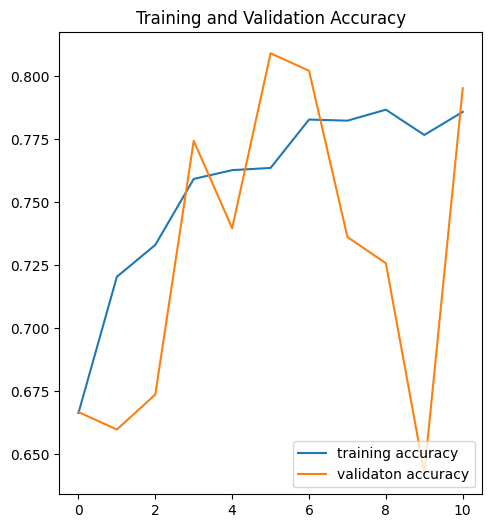

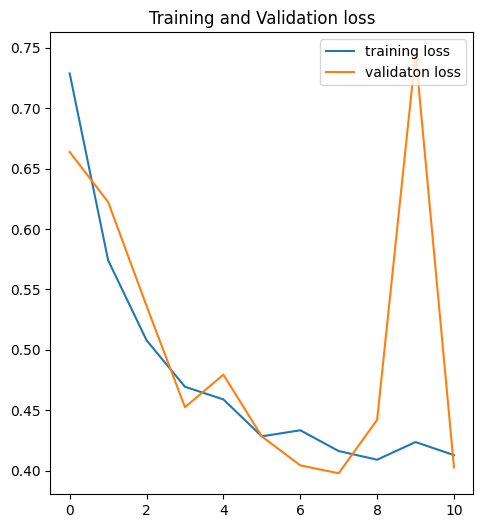

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss =history.history['loss']
val_loss = history.history['val_loss']

EPOCHS = len(acc)
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.plot(range(EPOCHS), acc, label = 'training accuracy')
plt.plot(range(EPOCHS), val_acc, label='validaton accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.plot(range(EPOCHS), loss, label = 'training loss')
plt.plot(range(EPOCHS), val_loss, label='validaton loss')
plt.legend(loc='upper right')
plt.title('Training and Validation loss')

## Evaluating Model Performance on Test Dataset

### Evaluation Process
1. **Model Evaluation**: The `evaluate()` method is used to evaluate the model's performance on the test dataset (`test_ds`). During evaluation, the model makes predictions on the test data and computes the loss and accuracy metrics.

2. **Test Loss**: The computed test loss represents the difference between the predicted outputs of the model and the actual labels in the test dataset. It indicates how well the model's predictions match the ground truth labels.

3. **Test Accuracy**: The test accuracy indicates the proportion of correctly classified instances in the test dataset. It provides insights into the overall performance of the model in terms of classification accuracy.

### Output Display
After evaluation, the test loss and test accuracy values are printed to the console for examination. This allows us to understand how well the model performs on unseen data and to identify any areas for improvement or potential issues, such as overfitting or underfitting.

### Interpretation
- **Optimal Performance**: High test accuracy and low test loss indicate that the model generalizes well to new data and performs effectively.
- **Issues to Address**: Low test accuracy or high test loss may indicate issues such as model overfitting, underfitting, or data imbalance, which may require further investigation and model refinement.

In [ ]:
test_loss, test_accuracy = model.evaluate(test_ds)
print("\nTest Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

10/10 [==============================] - 33s 1s/step - loss: 0.3917 - accuracy: 0.7563

Test Loss: 0.39172327518463135
Test Accuracy: 0.7562500238418579


In [ ]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)
    predictions = model.predict(img_array)
    predicted_class = class_names[np.argmax(predictions[0])]
    confidance = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidance

## Visualizing Model Predictions on Test Images

### Interpretation
- **Image Visualization**: Each subplot displays an image from the test dataset along with annotations indicating the actual class, predicted class, and confidence score.
- **Comparing Predictions**: By visually inspecting the images and their predictions, we can assess how accurately the model classifies different types of images and identify any misclassifications or areas for improvement.

Overall, this visualization provides a qualitative assessment of the model's performance on individual images and enhances our understanding of its classification capabilities.


1/1 [==============================] - 0s 67ms/step


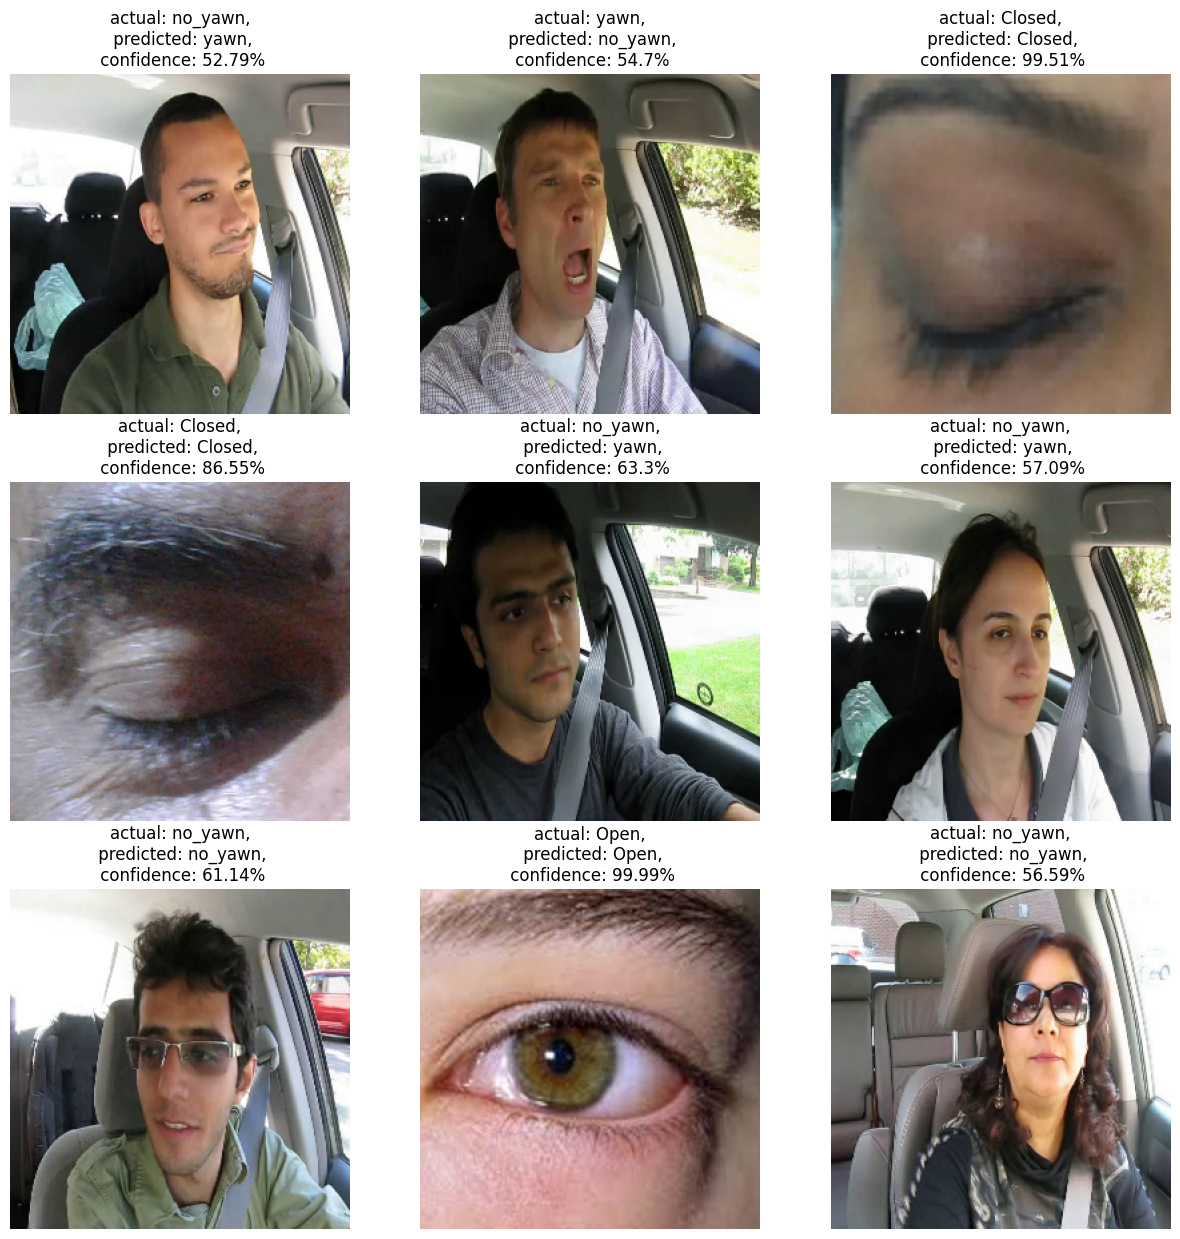

In [ ]:
plt.figure(figsize=(15,15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype('uint8'))

        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]
        plt.title(f"actual: {actual_class},\n predicted: {predicted_class},\n confidence: {confidence}%")
        plt.axis('off')


In [ ]:
model.save('model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


10/10 [==============================] - 15s 2s/step


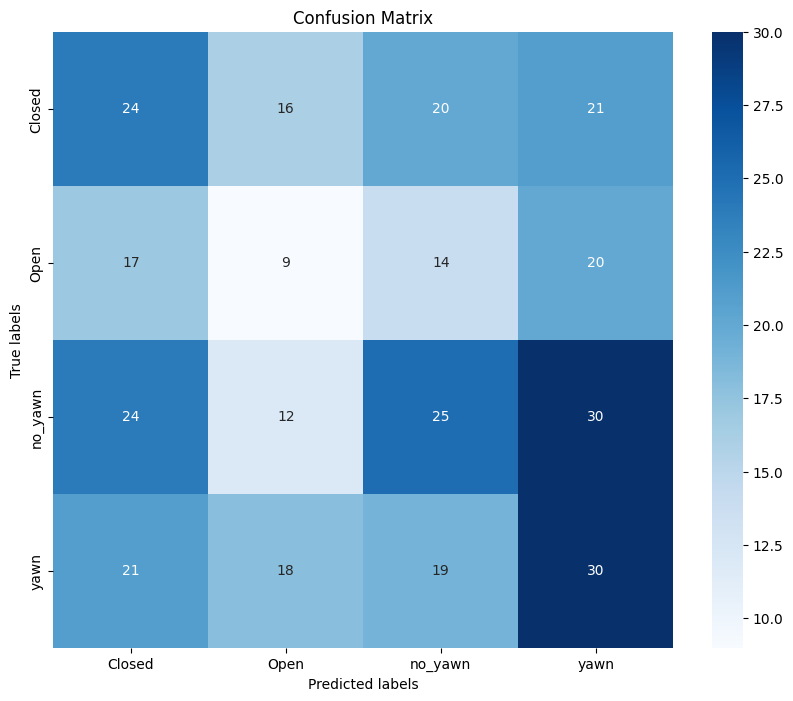

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

predictions = model.predict(test_ds)
y_pred = np.argmax(predictions, axis=1)
y_true = np.concatenate([y for x, y in test_ds], axis=0)
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()


In [ ]:
from sklearn.metrics import classification_report
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))


Classification Report:
              precision    recall  f1-score   support

      Closed       0.28      0.30      0.29        81
        Open       0.16      0.15      0.16        60
     no_yawn       0.32      0.27      0.30        91
        yawn       0.30      0.34      0.32        88

    accuracy                           0.28       320
   macro avg       0.27      0.27      0.26       320
weighted avg       0.27      0.28      0.27       320

